# Building A Classification Model for the Pulsar Dataset

Aziz Alkorey, Charmaine Halim, Francis Diokno, Jules Desre-Crouch

## Introduction

Pulsars emit two beams of light in opposite directions. Although the beam's light is steady, pulsars appear to flicker because they rotate. As the pulsar rotates, the light beam may sweep over the Earth, swinging in and out of view, creating the impression that the pulsar is blinking to an astronomer.

Because pulsars are important space objects that allow scientists to study extreme states of matter and cosmic events, it would be great if we had a system to predict whether a particular space object is a pulsar. Therefore, can we use the information from the data set to determine whether or not we can use it to create a model that can predict a pulsar star.

The data set contains nine columns. Eight continuous variables and one class variable. The first four variables are statistics derived from a pulsar’s integrated pulse profile, which are unique to a pulsar, whereas the latter four are derived from the DM-SNR (Dispersion Measure of Signal Noise Ratio).

## What We Expect To Find
We expect to find that we should be able to get a prediction of whether or not a candidate is a pulsar or not. This will be done by using all of the numerical variables into the recipe.

Using this prediction, we would be able to predict if newly discovered stars are pulsars, given that the data we collect is part of our prediction model. We will take 75% of the above data frame to train our model while using the other 25% to test our model.

This could lead to further questions such as:

- What’s the minimum/maximum DM-SNR curve for a certain star for it to no longer be considered a pulsar?
- What is the average skewness of a pulsar? And for non-pulsars?

## The Method We Plan to Use To Create the Model
The way in which we plan to conduct our data analysis is to use the K-nearest neighbours algorithm in order to predict whether or not a candidate is a pulsar star or not. Each of the statistical variables (mean, standard deviation, excess_kurtosis, and skewness) for each profile end curve will be used as the features of a star to train our model with.

One way to visualise the results is to use a scatter plot matrix. This would be a good choice since we are analysing 8 total variables, and it is only possible to analyse two variables per plot. As such, a scatter plot matrix would be a good choice because it enables us to view the relationship between several pairs of variables on a single chart. Colour could also be added to the scatter plot backgrounds to clearly showcase the KNN model decisions.

## Downloading Packages and Libraries

In [1]:
library(repr)
library(dplyr)
library(tidyverse)
library(tidymodels)
install.packages("themis")
library(themis)
library(GGally)
options(repr.matrix.max.rows = 10)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ stringr 1.4.0
✔ tidyr   1.2.0     ✔ forcats 0.5.1
✔ readr   2.1.2     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales

## Downloading the Dataset

This code cell contains the code to download the unscaled pulsar data set from the web.

In [2]:
pulsar_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
download.file(pulsar_url, "HTRU2.zip")
unzip("HTRU2.zip")

## Reading and Tidying the Dataset

The code cell below shows the code to read and tidy the unscaled dataset. We tidied the dataset by adding readable column names, where intp means *integrated pulse profile*, xs is *excess*, dmsnr is *dispersion measure of signal to noise ratio*, and std_dev stands for *standard deviation*. Furthermore, we added an new column called id that corresponds to the observation number. Because we are doing classification, the class variable which is the *class* variable is set to a factor category from a number, and instead of representing the class with binary numbers (0 and 1), we changed it to *"pulsar"* and *"non-pulsar"*.

In [3]:
pulsar_data <- read_csv("HTRU_2.csv", col_names = FALSE) |> 
    # Add column names:
    rename(mean_intp = X1, 
           std_dev_intp = X2, 
           xs_kurtosis_intp = X3, 
           skewness_intp = X4, 
           mean_dmsnr = X5, 
           std_dev_dmsnr = X6, 
           xs_kurtosis_dmsnr = X7, 
           skewness_dmsnr = X8, 
           class = X9) |>
    tibble::rowid_to_column('id') |> # Adds an id to each individual pulsar star candidate.
    mutate(class = as_factor(class), id = as_factor(id)) |> # Change class from dbl to factor (category) as these are categorial variables.
    select(id, class, everything()) |> # Reorder class as the first column in the table for organization purposes.
    mutate(class = case_when(class == 0 ~ "non_pulsar",
                            class == 1 ~ "pulsar")) # Clarify the classes.

pulsar_data

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id,class,mean_intp,std_dev_intp,xs_kurtosis_intp,skewness_intp,mean_dmsnr,std_dev_dmsnr,xs_kurtosis_dmsnr,skewness_dmsnr
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,non_pulsar,140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222
2,non_pulsar,102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358
3,non_pulsar,103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191
4,non_pulsar,136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366
5,non_pulsar,88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
17894,non_pulsar,136.4297,59.84742,-0.1878456,-0.73812297,1.296823,12.16606,15.450260,285.931022
17895,non_pulsar,122.5547,49.48561,0.1279781,0.32306090,16.409699,44.62689,2.945244,8.297092
17896,non_pulsar,119.3359,59.93594,0.1593631,-0.74302540,21.430602,58.87200,2.499517,4.595173


## Spliting the Data into Training and Testing Data

In order to create an accurate and unbiased classification mode, we must first divide the dataset into training and testing sets. We will use the training set to train the model and the testing set to test the model. This way, when the model is tested it will work on data it has never seen before. Here, we split it into 75% training set and 25% for testing set. In order to ensure that about the same percentage of each class appears in both the training and testing sets, we stratify the class variable.

In [4]:
set.seed(2002)

# Split data into training and testing data

pulsar_data_split <- initial_split(pulsar_data, prop = 0.75, strata = class)
pulsar_data_train <- training(pulsar_data_split)
pulsar_data_testing <- testing(pulsar_data_split)

## Class Distribution Graph (before balancing)

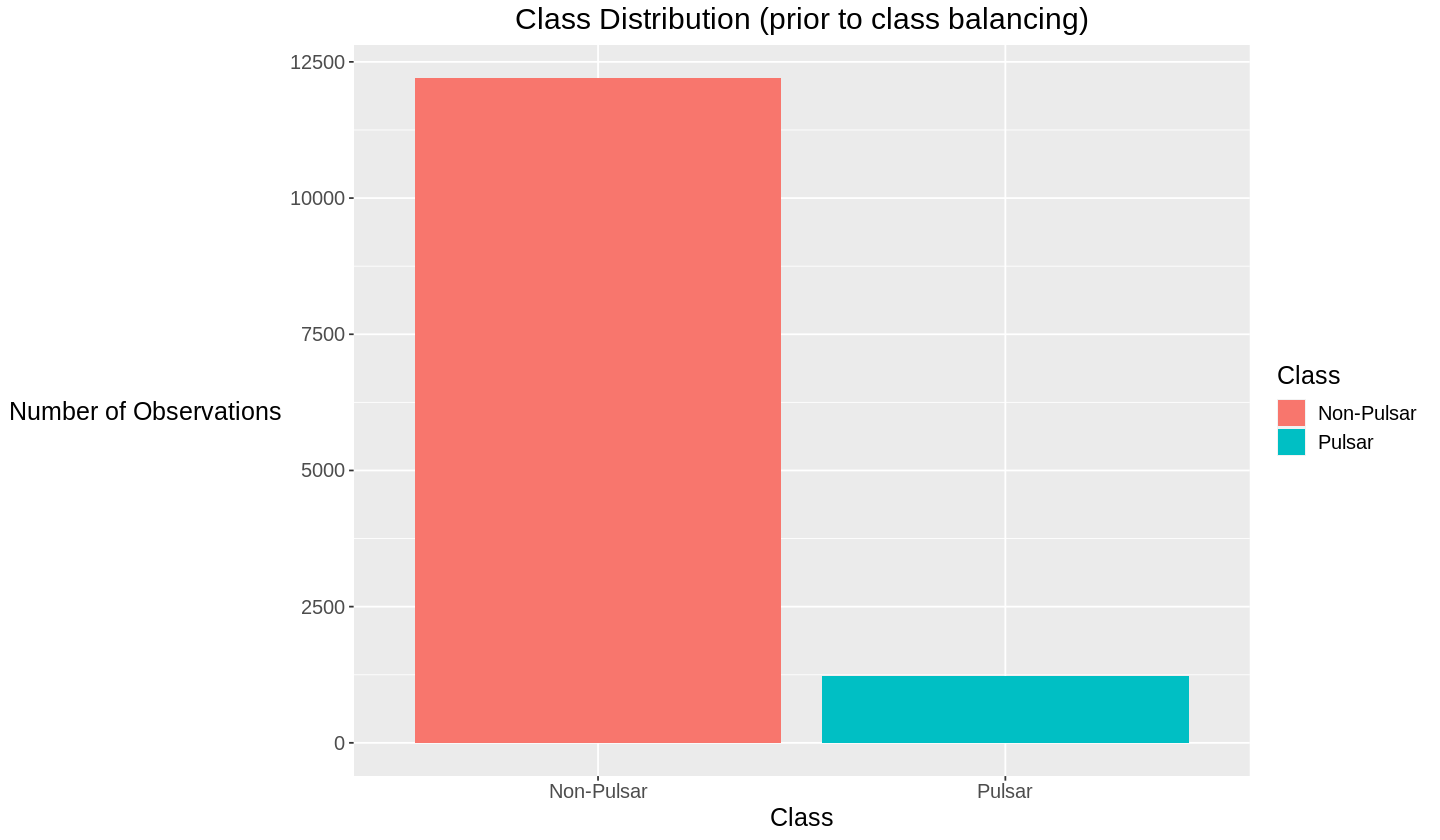

In [5]:
options(repr.plot.width = 12, repr.plot.height = 7)
class_distribution_plot_1 <- pulsar_data_train |>
                             mutate(class = case_when(class == "non_pulsar" ~ "Non-Pulsar",
                                                      class == "pulsar" ~ "Pulsar")) |> # Change class names (only for this plot) to titlecase for readability.
                             ggplot(aes(x = class, fill = class)) +
                             geom_bar() + labs(x = "Class", y = "Number of Observations", fill = "Class", title = "Class Distribution (prior to class balancing)") +
                             theme(text = element_text(size = 15),
                                   plot.title = element_text(hjust = 0.5),
                                   axis.title.y = element_text(angle = 0, vjust = 0.5, margin = margin(r = 5, unit = "pt")))
class_distribution_plot_1

From the graph we can clearly see that the classes aren't balanced as there is a much greater proportion of non-pulsars compared to pulsars.

## Balancing the Classes

We balanced the data by downscaling the majority class, which is the *"non-pulsars"*. We decided to downsample the *non-pulsars* instead of upsampling the *pulsars* because though both methods were able to successfully balance the classes, the upsampling method duplicated already existing points from the minority class, which ended up negatively effecting out optimal k value. 

In [6]:
set.seed(2002)
# Balancing the classes

ups_recipe <- recipe(class ~ ., data = pulsar_data_train) |>
              step_downsample(class, under_ratio = 1, skip = FALSE) |>
              prep()

pulsar_data_training <- bake(ups_recipe, pulsar_data_train)

pulsar_data_training

id,mean_intp,std_dev_intp,xs_kurtosis_intp,skewness_intp,mean_dmsnr,std_dev_dmsnr,xs_kurtosis_dmsnr,skewness_dmsnr,class
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
4029,102.4922,40.77338,0.26512930,1.5441063,8.073579,37.02852,4.680449,21.15971,non_pulsar
9546,110.4453,55.25238,0.11425968,-0.5991983,5.388796,28.04187,5.570570,31.69249,non_pulsar
11978,120.6016,39.64084,0.30622866,0.8938234,8.260870,35.10703,4.475239,20.02174,non_pulsar
11119,102.0859,47.91252,0.36011235,0.2816632,2.626254,17.03690,9.190054,98.91683,non_pulsar
12970,130.1094,55.88342,0.07224081,-0.5109587,2.569398,14.57369,8.700873,102.89946,non_pulsar
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
17460,39.95312,31.47218,3.881383,20.5227224,33.9891304,68.01901,1.9606233,2.564720,pulsar
17473,95.14844,46.66856,1.054644,1.9257564,99.3060201,102.46457,0.2734398,-1.757865,pulsar
17516,89.86719,47.48229,1.591325,2.5050565,0.7633779,12.39356,17.9407446,333.902630,pulsar


## Class Distribution Graph (after balancing)

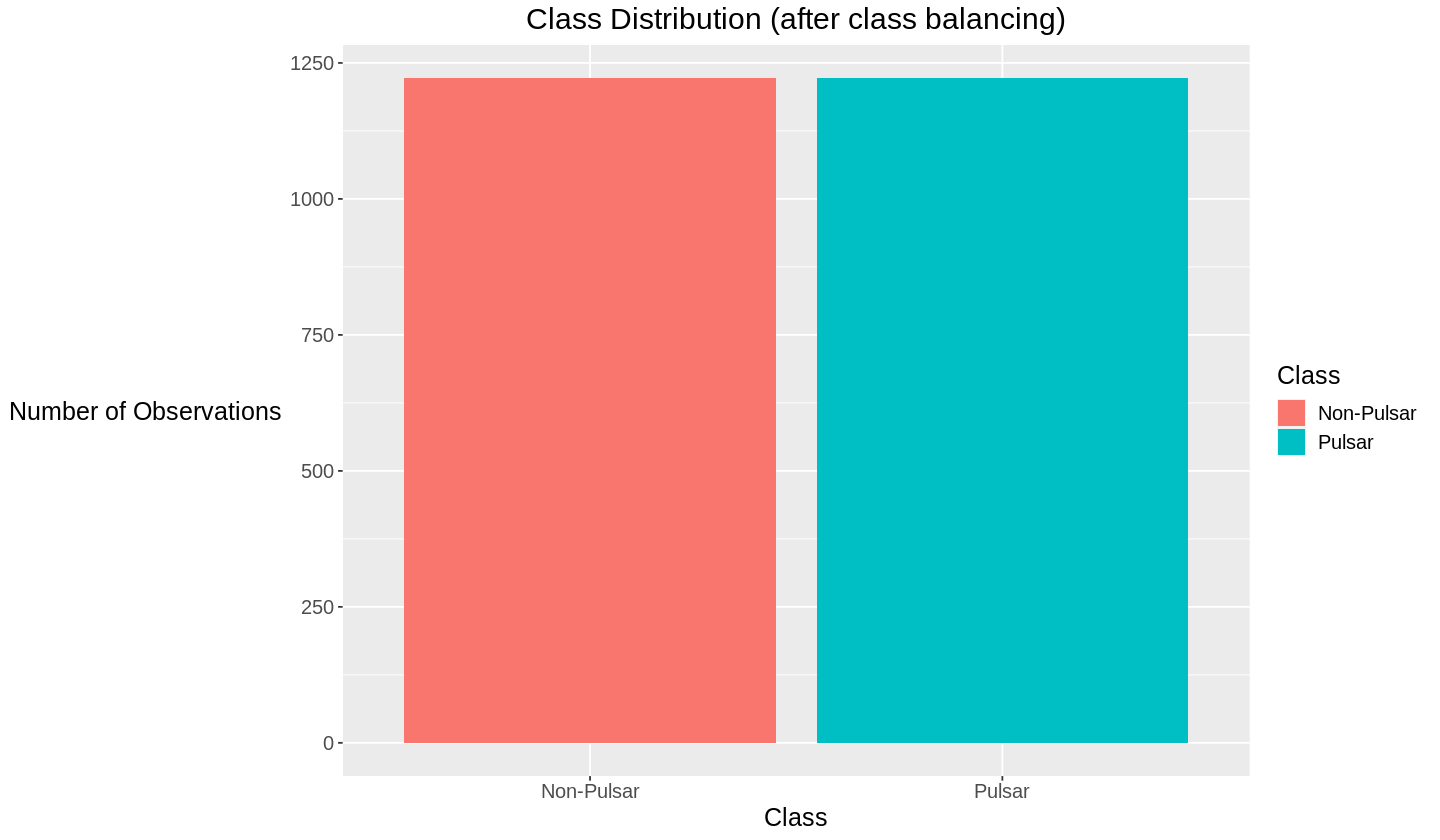

In [7]:
options(repr.plot.width = 12, repr.plot.height = 7)
class_distribution_plot <- pulsar_data_training |>
                           mutate(class = case_when(class == "non_pulsar" ~ "Non-Pulsar",
                                                    class == "pulsar" ~ "Pulsar")) |> # Change class names (only for this plot) to titlecase for readability.
                           ggplot(aes(x = class, fill = class)) +
                           geom_bar() + labs(x = "Class", y = "Number of Observations", title = "Class Distribution (after class balancing)", fill = "Class") +
                           theme(text = element_text(size = 15),
                                 plot.title = element_text(hjust = 0.5),
                                 axis.title.y = element_text(angle = 0, vjust = 0.5, margin = margin(r = 5, unit = "pt")))
class_distribution_plot

From this graph, we can now see that the two classes are balanced and we can now proceed with creating the classification model.

## Scatter Plot Matrix

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



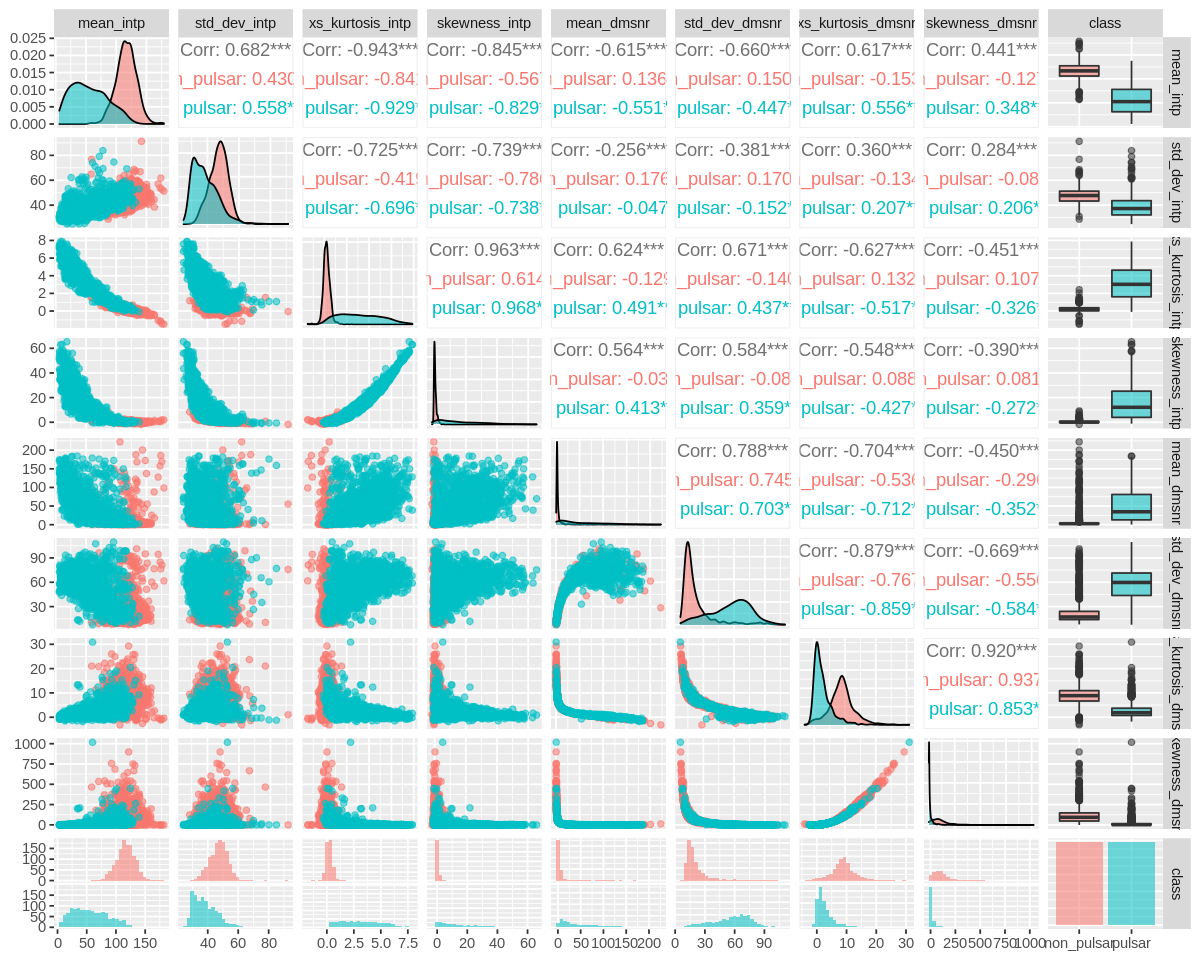

In [22]:
options(repr.plot.width = 10)
scatter_matrix <- pulsar_data_training |>
                  ggpairs(columns = 2:10, mapping=ggplot2::aes(colour = class, alpha = 1))
scatter_matrix

From the graph above, we can see that in the class column, there is a series of box plots for each numerical variable. In this graph, the color pink represents the non-pulsars and the blue color represents the pulsars. We can see from the box plots that for each numerical variable, the box plots vary quite differently for non-pulsars and pulsars, meaning tht the median for pulsars and non-pulsars are very different, giving us a reason to choose all the numerical variables as predictors. Another reason why we chose all numerical variables as predictors is that all these variables either is a statistical description of *intp* (Integrated Pulse Profile) or *dmsnr* (Dispersion Measure of Signal to Noise Ratio) which are both important features of a pulsar star. This can be found in R.J. Lyon's paper *"Why Are Pulsars Hard To Find?"* in page 55 where it states that *"producing one of the most important summary plots for a candidate,
its integrated pulse profile"* and pages 56-57 where he describes the importance of dm-snr as a feature of a candidate.

## Creating the Recipe

We chose the class column as the class variable and all other numerical variables as predictors. Then we standardized all predictors by scaling and centering. We do this so that each predictor variable has equal impact on the model.

In [8]:
set.seed(2002)
pulsar_data_recipe <- recipe(class ~ mean_intp + std_dev_intp + xs_kurtosis_intp + skewness_intp + mean_dmsnr + std_dev_dmsnr +
                                     xs_kurtosis_dmsnr + skewness_dmsnr, data = pulsar_data_training) |>
                      step_scale(all_predictors()) |>
                      step_center(all_predictors())


## Finding Optimal K-value
### Creating the KNN Model Specification

In [9]:
set.seed(2002)
pulsar_data_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                    set_engine("kknn") |>
                    set_mode("classification")

### Create Folds of the Training Data for Cross Validation

Here we are creating 5 folds from the training data to conduct cross validation in order to find the optimal value of k. Again, we are setting strata = class so that each fold will have an equal proportion of each class.

In [10]:
# Create cross validation using training data
set.seed(2002)
pulsar_data_vfold <- vfold_cv(pulsar_data_training, v = 5, strata = class)


### Create the Workflow 

In [11]:
# Create workflow
set.seed(2002)

grid_vals <- tibble(neighbors = 1:10)

pulsar_data_results <- workflow() |>
                       add_recipe(pulsar_data_recipe) |>
                       add_model(pulsar_data_tune) |>
                       tune_grid(resamples = pulsar_data_vfold, grid = grid_vals) |>
                       collect_metrics()

## Pulling the Optimal K-Values

First, we filter the .metric column so that it only contains "accuracy". Then get the maximum mean for the accuracies and pull the neighbours. This method ensures that you get the most accurate k-value/s.

In [12]:
pulsar_data_accuracy_results <- pulsar_data_results |>
                       filter(.metric == "accuracy") # Filters to only the accuracy metric.

pulsar_data_accuracy_results

pulsar_data_optimal_k <- pulsar_data_accuracy_results |>
                         filter(mean == max(mean)) |>
                         select(neighbors) |> # Gets the optimal k-value.
                         pull()

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9165490,5,0.009283479,Preprocessor1_Model01
2,accuracy,binary,0.9165490,5,0.009283479,Preprocessor1_Model02
3,accuracy,binary,0.9316912,5,0.007948410,Preprocessor1_Model03
4,accuracy,binary,0.9316912,5,0.007948410,Preprocessor1_Model04
5,accuracy,binary,0.9312697,5,0.007031135,Preprocessor1_Model05
6,accuracy,binary,0.9312697,5,0.007031135,Preprocessor1_Model06
7,accuracy,binary,0.9341385,5,0.008248614,Preprocessor1_Model07
8,accuracy,binary,0.9341385,5,0.008248614,Preprocessor1_Model08
9,accuracy,binary,0.9329090,5,0.007674446,Preprocessor1_Model09


## Optimal K-value

We can see that the optimal k values is 7 and 8. Further evidence is shown in the graph below.

In [13]:
pulsar_data_optimal_k

[1] 7 8

## Plotting K-values Vs. Accuracy Estimates

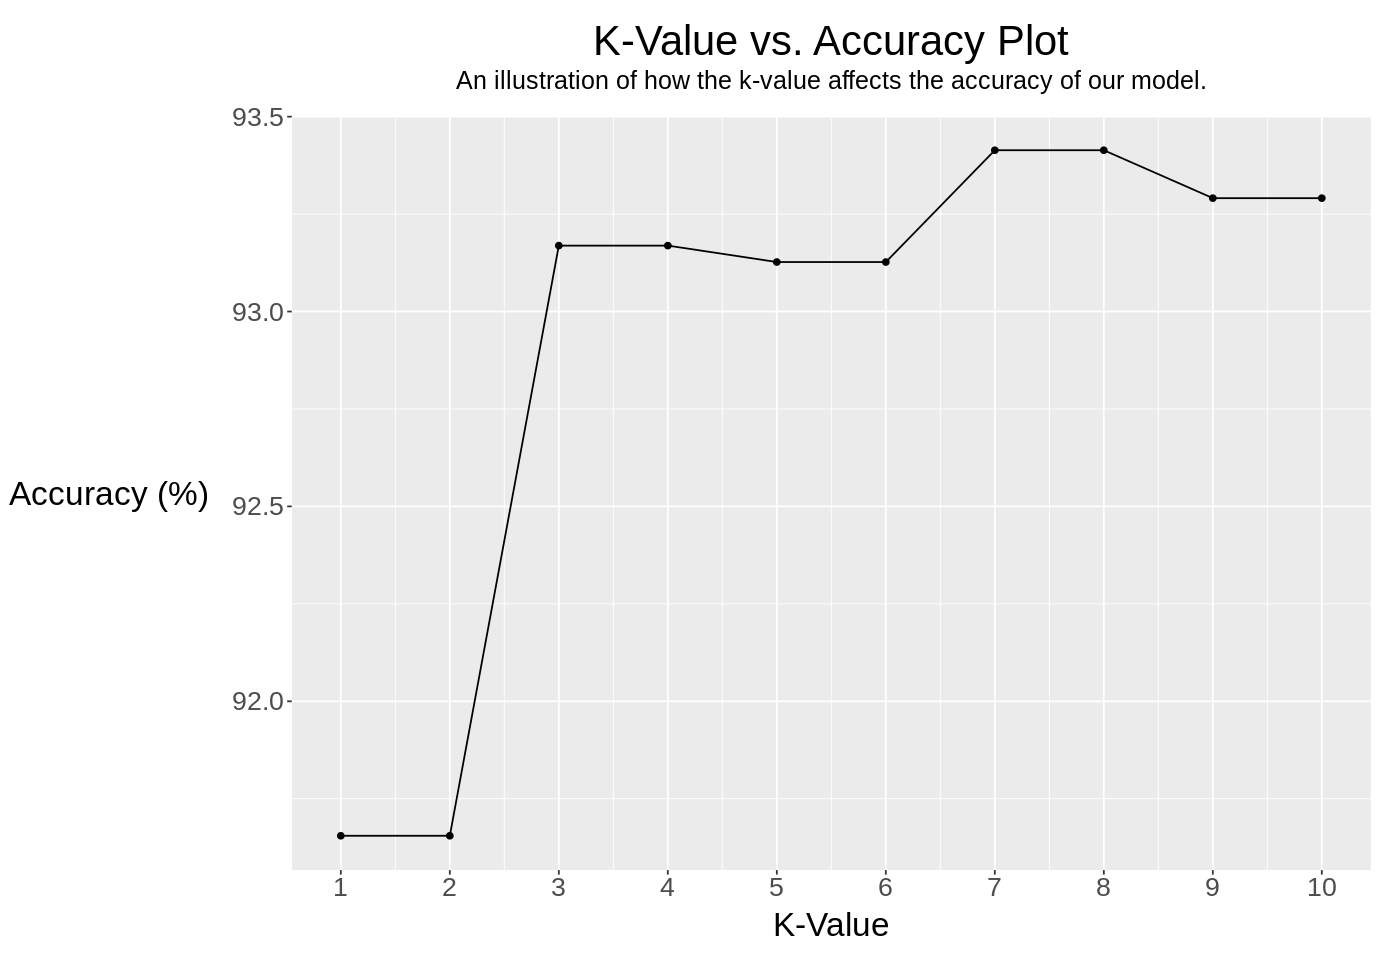

In [14]:

options(repr.plot.width = 11.5, repr.plot.height = 8) # Resize the plot.

# pulsar_data_results |>
#     filter(.metric == "accuracy") # Uncomment this to show all accuracies in a table.

pulsar_data_results_plot <- pulsar_data_results |>
                filter(.metric == "accuracy") |>
                select(neighbors, mean) |>
                mutate(mean = mean*100) |> # Converts the accuracy from a decimal to a percentage.
                ggplot(aes(x = neighbors, y = mean)) +
                geom_line() + 
                geom_point() +
                labs(x = "K-Value", 
                     y = "Accuracy (%)", 
                     title = "K-Value vs. Accuracy Plot", 
                     subtitle = "An illustration of how the k-value affects the accuracy of our model.") +
                theme(text = element_text(size=20), 
                      plot.subtitle = element_text(size=15, hjust = 0.5, margin = margin(b = 13, unit = "pt")), 
                      plot.title = element_text(size = 25, hjust = 0.5, margin = margin(t = 10, b = 5, unit = "pt")),
                      axis.title.y = element_text(size=20, angle = 0, vjust = 0.5, margin = margin(r = 13.5, unit = "pt")),
                      axis.title.x = element_text(size=20, vjust = -0.25, margin = margin(t = 2, b = 10, unit = "pt"))) + # Makes the text more readable.
                scale_x_continuous(breaks = 1:10) # Make the x-axis values go from the integers 1-10.

pulsar_data_results_plot

From the plot, we can see that the $k$-values that yield the most accurate results are 7 and 8. In this case, the $k$-value of 7 is the most optimal for our model as it is an odd number thus preventing ties from occuring when comparing the ratio of pulsars and non-pulsars during classification.

## Use Optimal K-Value to Create the Classification Model
### Building a New Specification

This time, instead of assigning *tune()* to neighbors, we are assigning the value 7, which is the optimal k-value we found above.

In [15]:
#using optimal K value to create the specification
set.seed(2002)
knn_specification <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |> 
                     set_engine("kknn") |> 
                     set_mode("classification")


### Create a Workflow and Fit into the Training Set.

We are creating a workflow with the recipe we created when tuning for optimal-k, but we used the new specification above. 

In [16]:
knn_fit <- workflow() |> 
                add_recipe(pulsar_data_recipe) |> 
                add_model(knn_specification) |> 
                fit(data = pulsar_data_training)

### Using the Model to Predict the Testing Set

In [17]:
knn_prediction <- predict(knn_fit, pulsar_data_testing) |> 
                  bind_cols(pulsar_data_testing)

knn_prediction2 <- knn_prediction |>
                   mutate(class = as_factor(class))
knn_prediction2

.pred_class,id,class,mean_intp,std_dev_intp,xs_kurtosis_intp,skewness_intp,mean_dmsnr,std_dev_dmsnr,xs_kurtosis_dmsnr,skewness_dmsnr
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
non_pulsar,9,non_pulsar,107.25000,52.62708,0.45268802,0.1703474,2.331940,14.48685,9.001004,107.97251
non_pulsar,12,non_pulsar,133.25781,44.05824,-0.08105986,0.1153615,1.632107,12.00781,11.972067,195.54345
non_pulsar,16,non_pulsar,114.36719,51.94572,-0.09449890,-0.2879841,2.738294,17.19189,9.050612,96.61190
pulsar,20,pulsar,99.36719,41.57220,1.54719697,4.1541060,27.555184,61.71902,2.208808,3.66268
non_pulsar,22,non_pulsar,105.44531,41.13997,0.14265380,0.3204197,3.551839,20.75502,7.739552,68.51977
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
non_pulsar,17885,non_pulsar,106.8750,47.57133,0.1994400,0.28496422,3.0794314,20.984455,8.427475,78.25937
non_pulsar,17886,non_pulsar,133.8203,43.47816,0.1366911,0.35312123,0.9824415,9.486068,18.528395,444.41175
non_pulsar,17893,non_pulsar,96.0000,44.19311,0.3886740,0.28134362,1.8712375,15.833746,9.634927,104.82162


### Getting the Metrics of the Classification Model

We want to see the accuracy of the model we created and whether or not we successfully build a classificatio model to predict whether or not an observation is a pulsar or not. Thus, we filter the the metrics to only show rows with "accuracy".

In [18]:
knn_metrics <-  knn_prediction2 |> 
                metrics(truth = class, estimate = .pred_class) |>
                filter(.metric == "accuracy")
knn_metrics


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9568715


From the results, we can see that our model has an accuracy of 95.7%. Therefore, we can conclude that the model we created is successful.

## Discussion
From the results, we can conclude that the model is a successful classification model as its accuracy is 95.6%, which means that the model has correctly predicted the class of most of the observations in the testing set. Therefore, this dataset can be used to create a successful classification model. 


## References

R.J. Lyon. *Why Are Pulsars Hard To Find*. PhD thesis. University of Manchester. 2016 

Cofield, Calla. *What Are Pulsars?* Space.com. Space, April 22, 2016. https://www.space.com/32661-pulsars.html. 